# Analysis of SARS-COV-2 virus neutalization in different Ace2 clones

This notebook analysis neutralization of SARS-COV-2/Wu-1 virus by sera from vaccinated individuals on 293T cell clones that express different levels of ACE2.

### Set up Analysis

In [1]:
import os
import warnings

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Set seaborn theme:

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data
We read in fraction infectivirty data for different cell lines and import sera information.

In [6]:
frac_infect = list() # create df list

for f in config['depletion_neuts'].keys():
    df = (pd.read_csv(f, index_col=0))
    frac_infect.append(df)  
frac_infect = pd.concat(frac_infect)



In [7]:
#read in sample info
sample_information = (pd.read_csv(config['sample_information'])
                      .drop_duplicates())

sample_information['sorted']=sample_information['subject_name'].str[:-1].astype(int)
sample_information = sample_information.sort_values('sorted')

#store sera names in a list to later convert to factors for plotting
cat_order_sera = sample_information['original_serum'].tolist()


In [14]:
#here I will merge sample_information with frac_infect on serum
df_newserumname= pd.merge(frac_infect, sample_information, on='original_serum')
df_newserumname

,original_serum,virus,replicate,concentration,fraction infectivity,cells,day,age,vaccine,subject_name,gender,serum,sorted
0,63C-day-10,pre-depletion,1,0.040000,0.000018,very low,10,18-55y,Pfizer,63C,Female,sample_1,63
1,63C-day-10,pre-depletion,1,0.010000,0.000027,very low,10,18-55y,Pfizer,63C,Female,sample_1,63
2,63C-day-10,pre-depletion,1,0.002500,-0.000010,very low,10,18-55y,Pfizer,63C,Female,sample_1,63
3,63C-day-10,pre-depletion,1,0.000625,-0.000006,very low,10,18-55y,Pfizer,63C,Female,sample_1,63
4,63C-day-10,pre-depletion,1,0.000156,0.058871,very low,10,18-55y,Pfizer,63C,Female,sample_1,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,194C-day-8,post-depletion,2,0.000625,NaN,high,8,18-55y,Pfizer,194C,Male,sample_10,194
1276,194C-day-8,post-depletion,2,0.000156,NaN,high,8,18-55y,Pfizer,194C,Male,sample_10,194
1277,194C-day-8,post-depletion,2,0.000039,NaN,high,8,18-55y,Pfizer,194C,Male,sample_10,194
1278,194C-day-8,post-depletion,2,0.000010,NaN,high,8,18-55y,Pfizer,194C,Male,sample_10,194


In [15]:
#read in ACE2 expression info
ACE2_expression_df = (pd.read_csv(config['ACE2_expression_df'])
                      .drop_duplicates())

In [17]:
frac_infect['original_serum'] = frac_infect['original_serum'] + '__' + frac_infect['cells']

frac_infect['virus'] = frac_infect['virus'].str.replace('post-depletion','depleted')
frac_infect['virus'] = frac_infect['virus'].str.replace('pre-depletion','not depleted')


In [19]:
fits = neutcurve.CurveFits(df_newserumname, fixbottom=0)

fitparams = (
    fits.fitParams()
    .rename(columns={'virus': 'RBD-targeting antibodies'})
    [['serum', 'RBD-targeting antibodies', 'ic50', 'ic50_bound']]
    .assign(NT50=lambda x: 1/x['ic50'])

    )

ValueError: duplicate concentrations for sample_1, pre-depletion, 1

In [25]:
fitparams

NameError: name 'fitparams' is not defined

## Fit Hill curve 

We use [`neutcurve`](https://jbloomlab.github.io/neutcurve/) to fit Hill curve for neutralization data and calcualte IC50 and NT50 values.

In [23]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

print(fitparams)

NameError: name 'fitparams' is not defined

In [11]:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)


In [12]:
fitparams[['sample', 'cells']] = fitparams['serum'].str.split('__', 1, expand=True)

In [13]:
#category for cell order so that ggplot does not use alphabetical
cat_order = ['very low', 'low', 'medium', 'high']
fitparams['cells'] = pd.Categorical(fitparams['cells'], categories=cat_order, ordered=True)

fitparams['sample'] = pd.Categorical(fitparams['sample'], categories=cat_order_sera, ordered=True)

In [14]:
#save data
fitparams.to_csv(config['neuts'], index=False)

## Plot IC50 values

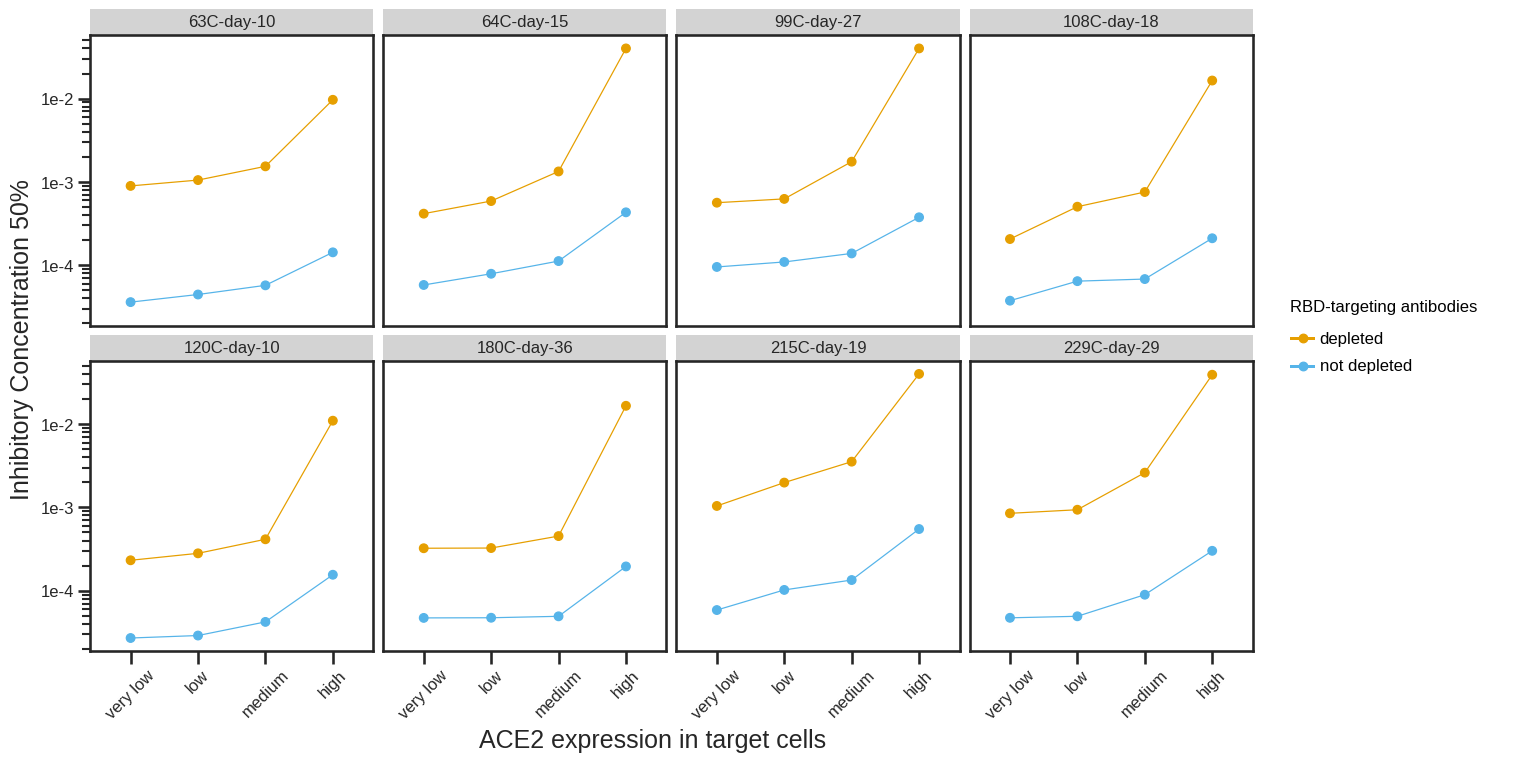

In [15]:
IC50 = (ggplot(fitparams, aes(x='cells', y='ic50', colour='RBD-targeting antibodies', group = 'RBD-targeting antibodies')) +
              geom_point(size=3) +
        geom_line(alpha=1) +
             theme(figure_size=(15,1*df['serum'].nunique()),
                   axis_text=element_text(size=12),
                   axis_text_x=element_text(size=12, angle= 45),
                   legend_text=element_text(size=12),
                   legend_title=element_text(size=12),
                   axis_title_x=element_text(size=18),
                   strip_text = element_text(size=12)
                  ) +
              facet_wrap('sample', ncol = 4)+
              scale_y_log10(name='Inhibitory Concentration 50%') +
              xlab('ACE2 expression in target cells') +
             scale_color_manual(values=CBPALETTE[1:])
                 )

_ = IC50.draw()
IC50.save(f'./{resultsdir}/IC50.pdf')

## Plot NT50 values

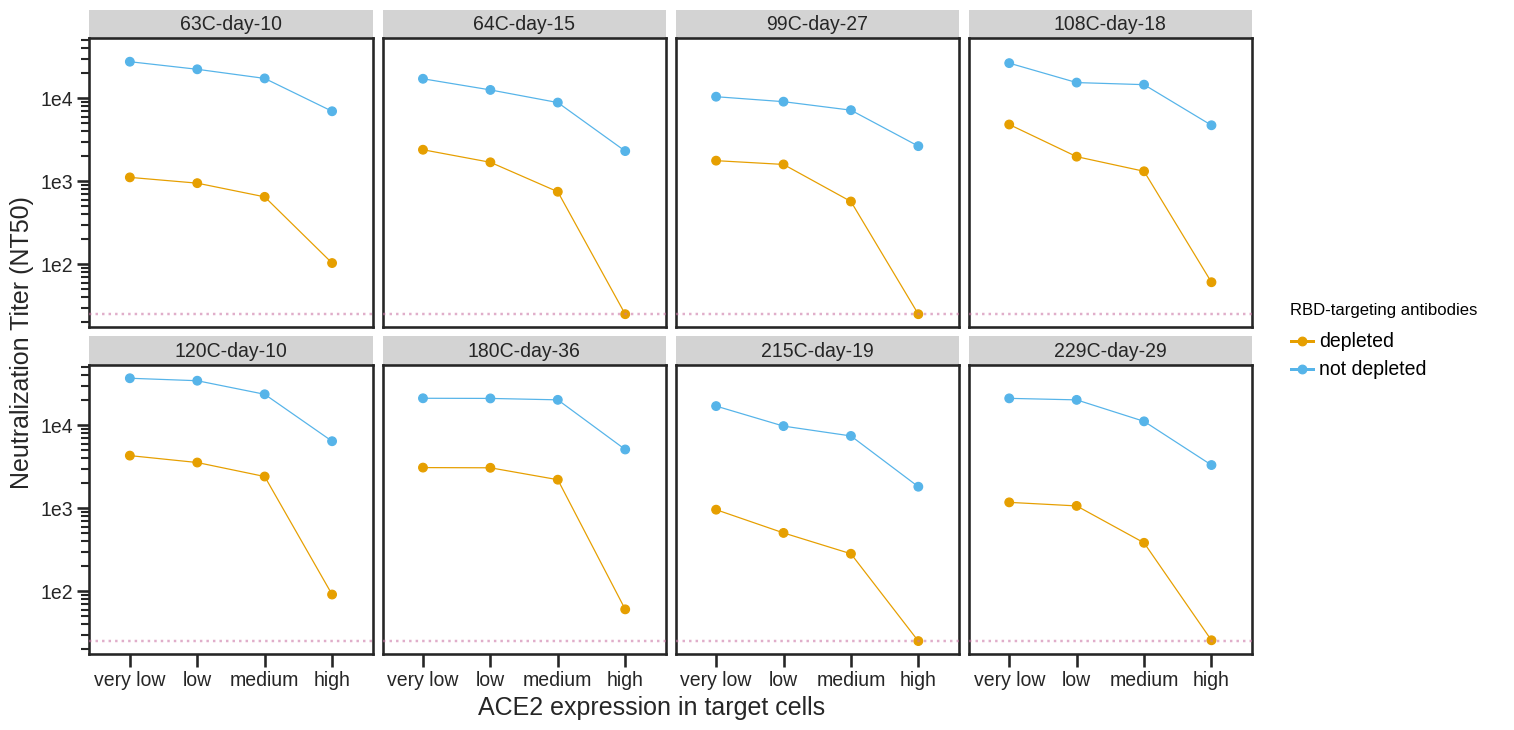

In [54]:
NT50 = (ggplot(fitparams, aes(x='cells', y='NT50', colour='RBD-targeting antibodies', group = 'RBD-targeting antibodies')) +
              geom_point(size=3) +
             geom_line(alpha=1) +
             theme(figure_size=(15,1*df['serum'].nunique()),
                   axis_text=element_text(size=14),
                   axis_text_x=element_text(size=14),
                   legend_text=element_text(size=14),
                   legend_title=element_text(size=12),
                   axis_title_x=element_text(size=18),
                   strip_text = element_text(size=14)
                  ) +
                geom_hline(yintercept=config['NT50_LOD'], 
                linetype='dotted',
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7]) +
              facet_wrap('sample', ncol = 4)+
              scale_y_log10(name='Neutralization Titer (NT50)') +
              xlab('ACE2 expression in target cells') +
              
             scale_color_manual(values=CBPALETTE[1:])
                 )

_ = NT50.draw()
NT50.save(f'./{resultsdir}/NT50.pdf')

In [41]:
#copy_merged = fitparams.merge(ACE2_expression_df[['column_you_want', 'other_column_you_want']], on='cells')

In [42]:
df_merged = pd.merge(fitparams, ACE2_expression_df, on='cells')
df_merged

,serum,RBD-targeting antibodies,ic50,ic50_bound,NT50,ic50_is_bound,sample,cells,MFI (mode),RLU/ul,relative MFI,relative RLU/ul
0,63C-day-10__very low,not depleted,0.000036,interpolated,27704.327890,False,63C-day-10,very low,1119,1830.92,0.018373,0.035987
1,63C-day-10__very low,depleted,0.000896,interpolated,1116.350361,False,63C-day-10,very low,1119,1830.92,0.018373,0.035987
2,64C-day-15__very low,not depleted,0.000058,interpolated,17250.386340,False,64C-day-15,very low,1119,1830.92,0.018373,0.035987
3,64C-day-15__very low,depleted,0.000416,interpolated,2404.654223,False,64C-day-15,very low,1119,1830.92,0.018373,0.035987
4,99C-day-27__very low,not depleted,0.000095,interpolated,10482.828819,False,99C-day-27,very low,1119,1830.92,0.018373,0.035987
5,99C-day-27__very low,depleted,0.000563,interpolated,1775.638252,False,99C-day-27,very low,1119,1830.92,0.018373,0.035987
6,108C-day-18__very low,not depleted,0.000038,interpolated,26631.940352,False,108C-day-18,very low,1119,1830.92,0.018373,0.035987
7,108C-day-18__very low,depleted,0.000206,interpolated,4846.872564,False,108C-day-18,very low,1119,1830.92,0.018373,0.035987
8,120C-day-10__very low,not depleted,0.000027,interpolated,36926.148194,False,120C-day-10,very low,1119,1830.92,0.018373,0.035987
9,120C-day-10__very low,depleted,0.000232,interpolated,4309.854579,False,120C-day-10,very low,1119,1830.92,0.018373,0.035987


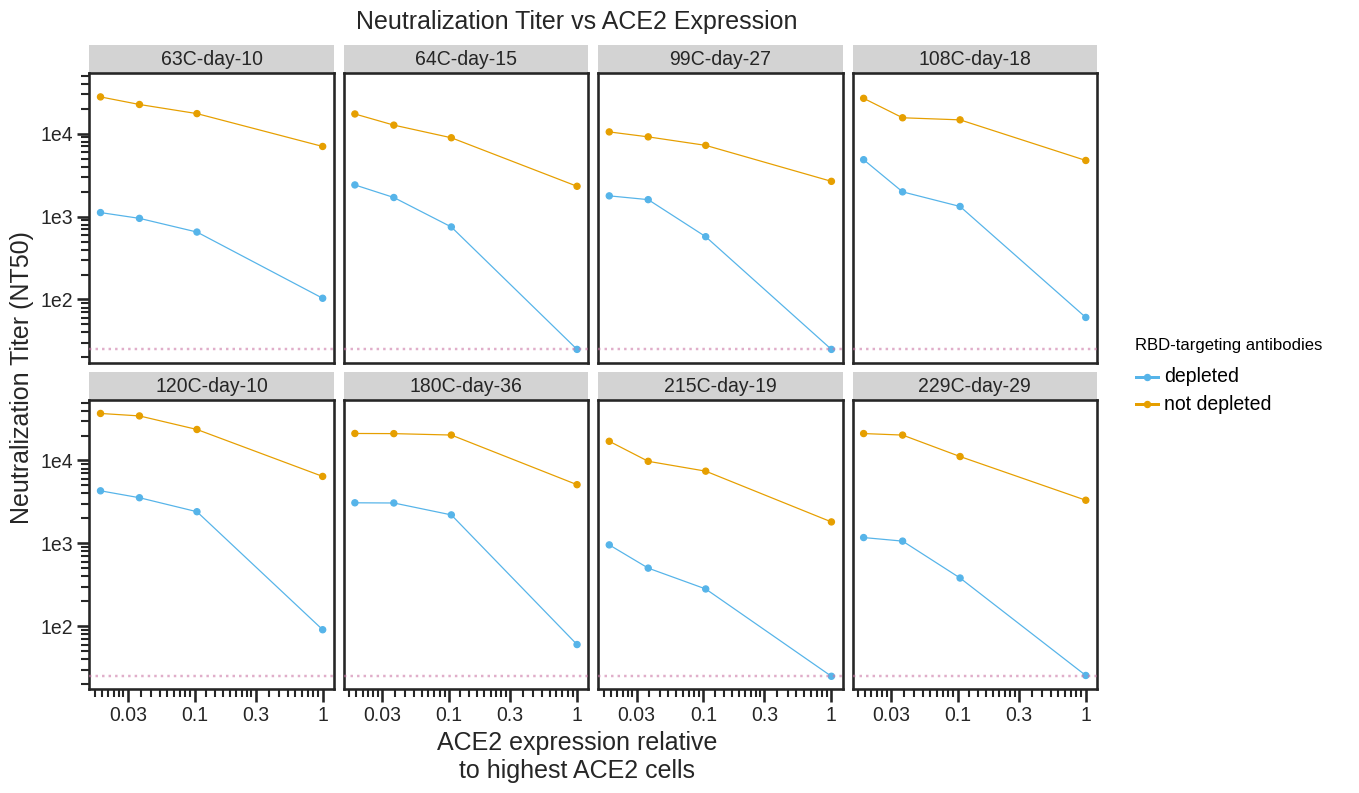

In [71]:
#how do I match this to Bernadeta's theme (unspecified above) as sizes get all messed up if I remove theme_classic
plot = (
    ggplot(df_merged) +
    aes(x="relative MFI", y="NT50", group='RBD-targeting antibodies', color='RBD-targeting antibodies')+
    geom_point(size=2) +
    geom_line() +
    theme(figure_size=(13,8),
          axis_text=element_text(size=14),
          axis_text_x=element_text(size=14),
          legend_text=element_text(size=14),
          legend_title=element_text(size=12),
          axis_title_x=element_text(size=18),
          strip_text = element_text(size=14)) +
    scale_color_manual(values= ['#56B4E9','#E69F00']) +
    labs(title="Neutralization Titer vs ACE2 Expression", x="ACE2 expression relative\nto highest ACE2 cells", y="Neutralization Titer (NT50)") +
    scale_x_log10() +
    scale_y_log10() +
    facet_wrap('sample', ncol=4) +
    geom_hline(yintercept=25,
                linetype='dotted', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7])
   

)

plot.draw()
plot.save(f'{resultsdir}/NT50_vs_ACE2_expression.pdf')

## Plot neut curves for all samples

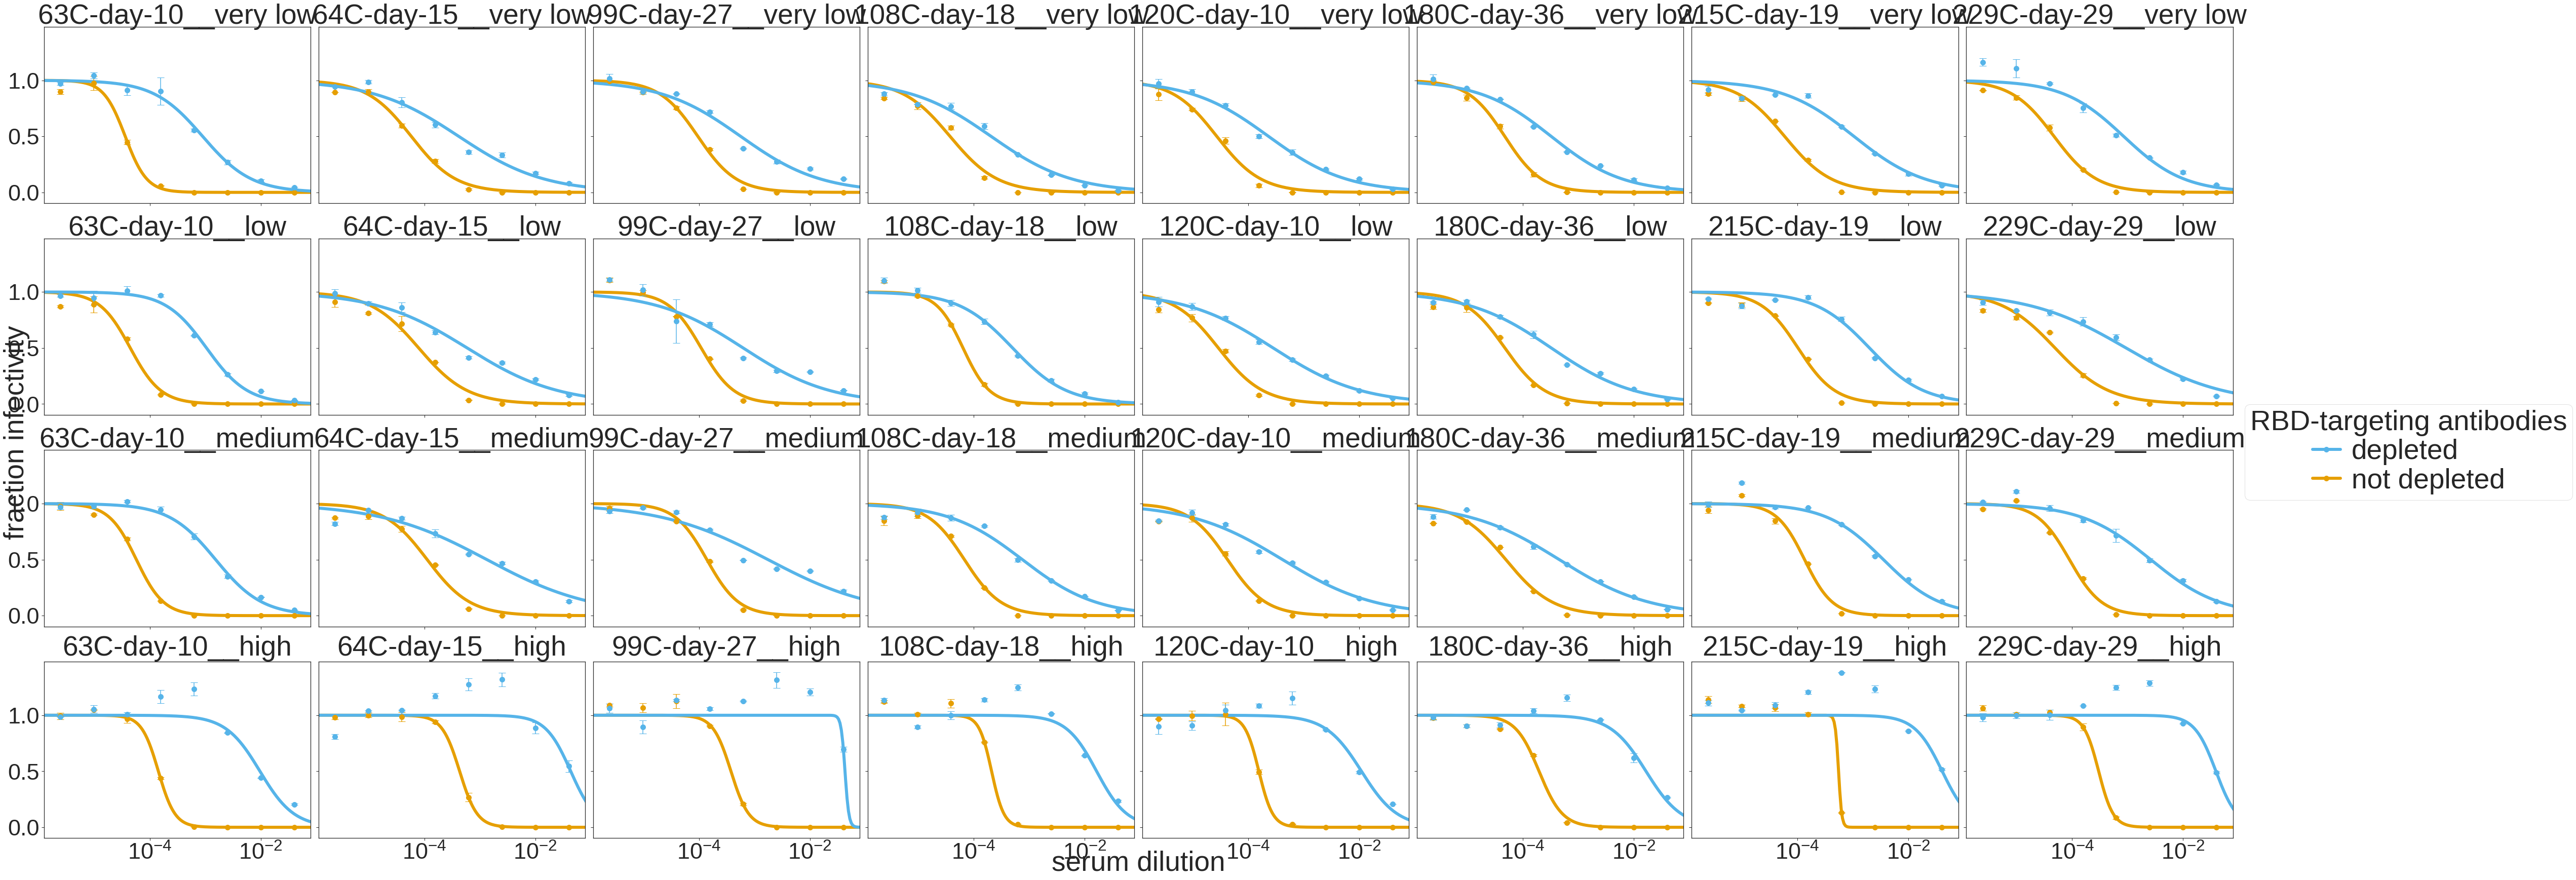

In [59]:
#why is adjusting the font size so non-linear?  How do I adjust size of axes titles? Also, once we swith sera names this should fit
#do we switch sera names in .csv file?
fig, axes = fits.plotSera(
                          xlabel='serum dilution',
                          ncol=8,
                          widthscale=2.5,
                          heightscale=2.5,
                          titlesize=55, labelsize=55, ticksize=45, legendfontsize=55, yticklocs=[0,0.5,1],
                          markersize=10, linewidth=6,
                          virus_to_color_marker={
                          'depleted': ('#56B4E9', 'o'),
                          'not depleted': ('#E69F00', 'o')},
                          legendtitle='RBD-targeting antibodies',
                    
                         )